In [1]:
import os
import glob
from os.path import join as pjoin
import glob
import pandas as pd
import numpy as np
# numpy's lnorm is equivalent to scipy.spatial.distance.euclidean (I checked), but faster. 
from numpy.linalg import norm as lnorm
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline

In [2]:
sns.set_context('notebook')
sns.set_style('ticks')

# Lihui's behavioral data

Inspect one of the subject's results for better understanding.

In [3]:
datadir = '/Users/Oliver/Desktop/Lihui_Data/RI/Exp2'

In [4]:
test_data = pd.read_hdf(pjoin(datadir, 'sub-001_ver1_sess1_Naming.hdf'))
test_data.head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum
0,stim_set/Loeffel.6_v2_percept.png,Löffel,"[Schere, Zahnpasta, Glas]",0,3,2.481411,"[-0.463541666667, -0.211111111111]",0,0
1,stim_set/Glas.3_v2_percept.png,Glas,"[Schere, Tasse, Flasche]",0,99,0.000000,"[-0.39375, -0.244444444444]",0,1
2,stim_set/Flasche.2_v2_percept.png,Flasche,"[Tasse, Banane, Schere]",0,99,0.000000,"[-0.555208333333, -0.231481481481]",0,2
3,stim_set/Flasche.3_v2_percept.png,Flasche,"[Glas, Schere, Apfel]",0,3,2.212549,"[0.501041666667, -0.22037037037]",0,3
4,stim_set/Schere.2_v2_percept.png,Schere,"[Zahnpasta, Flasche, Glas]",0,3,2.833762,"[-0.222916666667, -0.224074074074]",0,4


Take the results from the second experiment, naming task.

# Compute Euclidean Distance between original and simulation

In [5]:
def comp_ed(sim_hmax, orig_hmax):
    """
    Read HMAX output files for simulated and original image with pandas.
    Compute Euclidean distance between the two.
    Return dict with ED, as well as file paths.
    """
    # simulated
    sim_df = pd.read_csv(sim_hmax, header=None)
    assert np.shape(sim_df[0]) == (2000,)

    # original
    orig_df = pd.read_csv(orig_hmax, header=None)
    assert np.shape(orig_df[0]) == (2000,)

    # compute euclidean distance
    ed = lnorm(sim_df[0]-orig_df[0])
    
    # get path names of pictures
    orig_pname = orig_hmax.replace('.ascii', '').replace('./results/', '')
    sim_pname = sim_hmax.replace('.ascii', '').replace('./results/', '')
    
    # return dict
    ed_dict = {
        'ed' : ed,
        'orig' : orig_pname,
        'sim' : sim_pname
    }
    return ed_dict

In [6]:
# Example

ed_dict = comp_ed(sim_hmax='./results/Apfel.1_v2_percept.png.ascii',
             orig_hmax='./results/Apfel.1_v1_new.jpg.ascii')

print(ed_dict)

{'ed': 8.966686528324578, 'sim': 'Apfel.1_v2_percept.png', 'orig': 'Apfel.1_v1_new.jpg'}


## Collect EDs for all relevant stimuli

In [7]:
# how many HMAX outputs have we?
# Should be 144 (80 originals + 64 simulations used by Lihui)
assert len(glob.glob('./results/*')) == 144

In [8]:
# My HMAX output
sim_flist = glob.glob('./results/*')
sim_flist.sort()
# sim_flist

In [9]:
# Names of Lihui's stimuli without file extension
picnames = [pathname.split('/')[-1].replace('_v2_percept.png','') for pathname in test_data.Img.unique()]
#picnames

In [10]:
# iterate through all relevant stimuli

# list of dicts to be filled
ed_dicts = []

for picname in picnames:
    # paths to hmax results
    orig_hmax = './results/' + picname + '_v1_new.jpg.ascii'
    sim_hmax = './results/' + picname + '_v2_percept.png.ascii'
    # ed
    ed_dict = comp_ed(sim_hmax, orig_hmax)
    ed_dicts.append(ed_dict)

assert len(ed_dicts) == 64

## Descriptive statistics

In [11]:
# only the distances
eds = [ed_dict['ed'] for ed_dict in ed_dicts]

In [12]:
print('mean ED: %f' % np.mean(eds))
print('standard deviation: %f' % np.std(eds))

mean ED: 15.477273
standard deviation: 1.607819


Text(0,0.5,'Count')

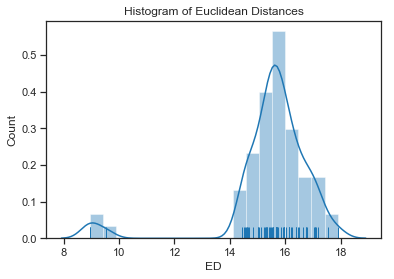

In [13]:
sns.distplot(eds, rug=True)

plt.title('Histogram of Euclidean Distances')
plt.xlabel('ED')
plt.ylabel('Count')

**Note:**
- Euclidean distances are not normally distributed due to some outliers with low values (these could be apples)
- Besides that, there seems to be enough variability in the EDs to use for prediction

## Find the outliers

In [14]:
sorted_ed_dicts = sorted(ed_dicts, key=lambda k: k['ed']) 

In [15]:
sorted_ed_dicts[:5]

[{'ed': 8.9413442994681489,
  'orig': 'Apfel.2_v1_new.jpg',
  'sim': 'Apfel.2_v2_percept.png'},
 {'ed': 8.966686528324578,
  'orig': 'Apfel.1_v1_new.jpg',
  'sim': 'Apfel.1_v2_percept.png'},
 {'ed': 9.52822620953396,
  'orig': 'Apfel.3_v1_new.jpg',
  'sim': 'Apfel.3_v2_percept.png'},
 {'ed': 14.44820836655,
  'orig': 'Apfel.7_v1_new.jpg',
  'sim': 'Apfel.7_v2_percept.png'},
 {'ed': 14.517777719989972,
  'orig': 'Loeffel.6_v1_new.jpg',
  'sim': 'Loeffel.6_v2_percept.png'}]

The three outliers are indeed some of the apples.

# Add ED to behavioral data
(as well as subject number)

We want to start with the results from experiment 2, naming task only, which are represented in hdf files.

In [16]:
# Show content of data directory

#sorted(glob.glob(datadir+'/*'))

# There's 32 subjects (subject 9 is missing).
# Each has 2 files: one for naming and one for discrimination task.

In [17]:
# Get list of file names for naming task only
hdf_files = sorted(glob.glob(datadir+'/*Naming*'))
assert len(hdf_files) == 32

In [18]:
# Read all files in pandas
behav_dfs = [pd.read_hdf(hdf_file) for hdf_file in hdf_files]

In [19]:
def insert_eds(df, ed_dicts):
    """
    Insert euclidean distances into a Data Frame.
    """
    # construct new list of euclidean distance, the order of which corresponds
    # to the order they should be inserted in the df
    df_eds = []
    for df_img in df.Img:
        for ed_dict in ed_dicts:
            if ed_dict['sim'] in df_img:
                df_eds.append(ed_dict['ed'])

    assert len(df_eds) == len(df)
    df['ED'] = df_eds
    return df
    # TODO: find more efficient way than nested loop.

In [20]:
dfs = [insert_eds(behav_df, ed_dicts) for behav_df in behav_dfs]

In [21]:
# Add subject number to each df
for df, sub_num in zip(dfs, range(1,len(dfs)+1)):
    df['sub'] = sub_num

In [22]:
# inspect example
dfs[10].head()

,Img,ImgName,AlterNames,Answer,Choice,RT,MousePos,Block,Trlnum,ED,sub
0,stim_set/Banane.2_v2_percept.png,Banane,"[Löffel, Tasse, Glas]",0,99,0.000000,"[-0.423958333333, -0.214814814815]",0,0,15.403279,11
1,stim_set/Glas.1_v2_percept.png,Glas,"[Zahnpasta, Banane, Apfel]",1,0,1.715044,"[0.120833333333, -0.233333333333]",0,1,15.666401,11
2,stim_set/Schere.1_v2_percept.png,Schere,"[Löffel, Banane, Zahnpasta]",0,3,2.019426,"[-0.39375, -0.222222222222]",0,2,16.131853,11
3,stim_set/Zahnpasta.5_v2_percept.png,Zahnpasta,"[Tasse, Löffel, Flasche]",0,2,1.912589,"[-0.430208333333, -0.240740740741]",0,3,15.685296,11
4,stim_set/Tasse.8_v2_percept.png,Tasse,"[Zahnpasta, Glas, Löffel]",1,0,2.509649,"[0.120833333333, -0.237037037037]",0,4,14.546847,11


# Compute centroids

We're only interested in the distance of simulated images from their centroids (for now).

In [23]:
# file names of simulated images
sim_pnames = ['./results/' + picname + '_v2_percept.png.ascii' for picname in picnames]

In [24]:
# Collect HMAX vectors of simulated images
sim_vecs = []
for sim_pname in sim_pnames:
    sim_df = pd.read_csv(sim_pname, header=None)
    sim_vecs.append(sim_df[0].values)
    
# stack result into arrays
sim_arr = np.array(sim_vecs)
# compute centroids
sim_centroid = np.mean(sim_arr, axis=0)

## Compute distance from centroid for every stimulus

In [25]:
# Compute distances from centroid (cd)

 # We'll need to iterate through filenames again to know which CD belongs to which stimulus

cd_dicts = []

for sim_pname in sim_pnames: 
    sim_df = pd.read_csv(sim_pname, header=None)
    sim_vec = sim_df[0].values
    sim_cd = lnorm(sim_vec-sim_centroid)
    sim_dict = {
        'sim' : sim_pname,
        'cd' : sim_cd
    }
    cd_dicts.append(sim_dict)

# The result is a list of dicts containing file names and CD for simulated images

## Centroid distance histogram

In [26]:
# list of centroid distances
cds = [cd_dict['cd'] for cd_dict in cd_dicts]

Text(0,0.5,'Count')

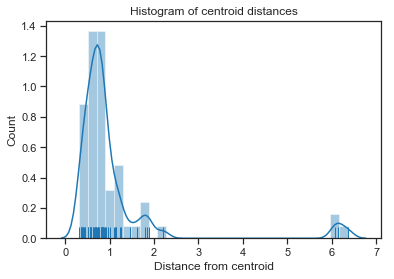

In [27]:
sns.distplot(cds, rug=True)

plt.title('Histogram of centroid distances')
plt.xlabel('Distance from centroid')
plt.ylabel('Count')

In [28]:
# Find outliers
sorted_cd_dicts = sorted(cd_dicts, key=lambda k: k['cd']) 
sorted_cd_dicts[-5:]

[{'cd': 1.8755911503546303, 'sim': './results/Tasse.2_v2_percept.png.ascii'},
 {'cd': 2.2026939808004755, 'sim': './results/Glas.3_v2_percept.png.ascii'},
 {'cd': 6.0777254246906507, 'sim': './results/Apfel.1_v2_percept.png.ascii'},
 {'cd': 6.1431500714742864, 'sim': './results/Apfel.3_v2_percept.png.ascii'},
 {'cd': 6.3581229685482672, 'sim': './results/Apfel.2_v2_percept.png.ascii'}]

Again, the three outliers are three of the apples.

## Add CD values to data frames

we will define a general function here and add them to the discrimination task data further below

In [29]:
def insert_cds(df, ed_dicts):
    """
    Insert centroid distances into a Data Frame.
    """
    # construct new list of euclidean distance, the order of which corresponds
    # to the order they should be inserted in the df
    df_cds = []
    for img in df.Img:
        for cd_dict in cd_dicts:
            if cd_dict['sim'].split('/')[-1].replace('.ascii', '') in img:
                df_cds.append(cd_dict['cd'])

    assert len(df_cds) == len(df)
    df['CD'] = df_cds
    return df

In [30]:
dfs = [insert_cds(df, cd_dicts) for df in dfs]

# Explorative plotting ED

## Reaction times and ED

For exploration, we want to plot the correlation between ED and RT seperately for each block.

- We will start with an example subject
- We can do the same for all subjects at once, treating each datapoint equally and ignoring inter-subject variability. This is only for exploration and does **not** allow statistical inference.

### Example subject

In [31]:
# take first subject as example
test_df = dfs[0]

In [32]:
# Subjects' non-responses yield an RT value of 0 and Choice value of 99.
# Exclude them here.
# However, this will become important later for actual statistical inference.

# test_df[test_df['RT']==0]


There are 7 non-response trials


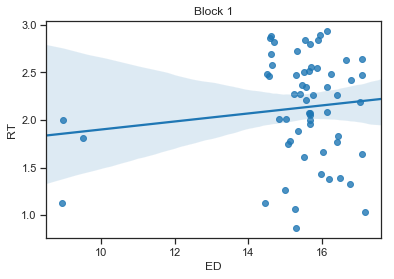

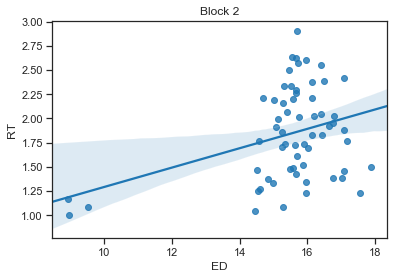

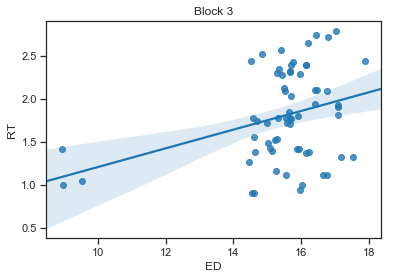

In [33]:
# Count number of non-response trials
print('\nThere are %i non-response trials' % len(test_df[test_df['Choice']==99]))

# Scatter plot the three blocks seperately
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=test_df[(test_df['Block']==block) & (test_df['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusion for example subject**
- This does not tell us much. If anything, it contradicts our intuition that ED should correlate more strongly with RT in the first Block than the other two.

- In general, the slope of the linear fit seems to be driven by the three outliers (i.e. the apples).

### All subjects

In [34]:
# concatinate dfs
df_concat = pd.concat(dfs)

# add task variable
df_concat['task'] = 'name'

In [35]:
# Validate

# the length
assert len(df_concat) == len(dfs[0]) * 32
# all subjects are there
np.unique(df_concat['sub'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

**Scatter plot RT and ED for the three blocks just as before**


There are 414 non-response trials


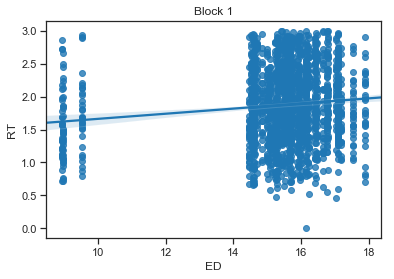

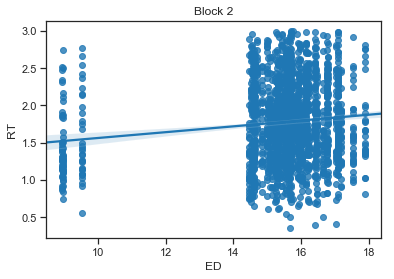

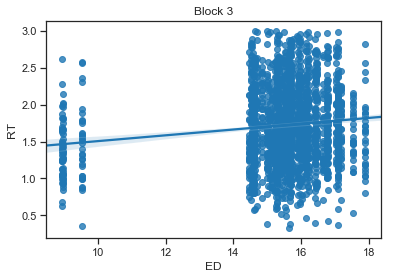

In [36]:
print('\nThere are %i non-response trials' % len(df_concat[df_concat['Choice']==99]))

for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=df_concat[(df_concat['Block']==block) & (df_concat['Choice']!=99)])
    plt.title('Block %i' % (block+1))
    plt.show()

**Exclude ED outliers (the three weird apples)**

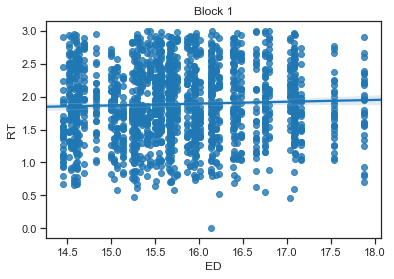

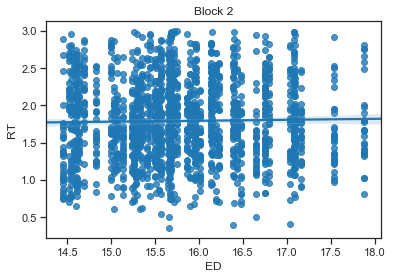

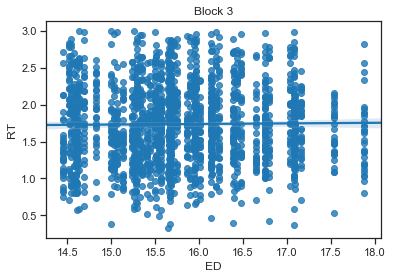

In [37]:
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=df_concat[(
                         df_concat['Block']==block) & (df_concat['Choice']!=99) & (df_concat['ED'] > 10)
                                   ])
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions from explorative correlations with RT:**

There seems to be *no correlation* between ED and RT in any of the blocks when outliers are removed. This makes it unlikely that a prediction of RT by HMAX difference would be successfull.

However, These correlations do not inform the potential *learning*, which would reflect in changes of RT / accuracy across the experiment. This could only be investigated with a real *statistical model*, such as LMM, regression, ANCOVA, or others.

## Accuracy and ED

### Boxplot

In [38]:
# with outliers
# sns.boxplot(x='Answer', y='ED', data=df_concat[df_concat['Choice']!=99])

Again, remove ED outliers:

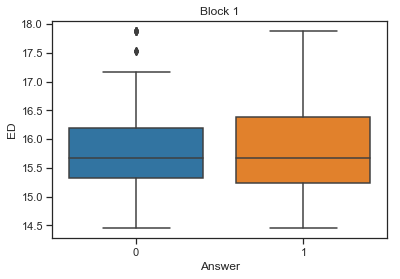

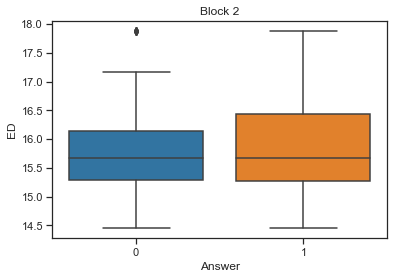

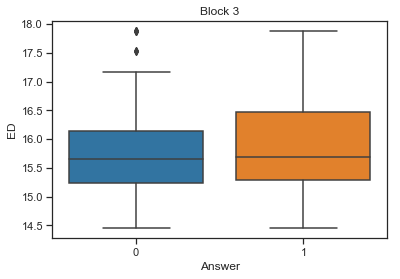

In [39]:
for block in range(3):
    sns.boxplot(x='Answer', y='ED',
                data=df_concat[ (df_concat['Choice']!=99) & (df_concat['ED']>10) & (df_concat['Block']==block)])
    plt.title('Block %i' % (block+1))
    plt.show()

### (Logistic) regression plot

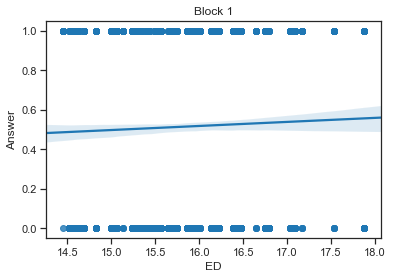

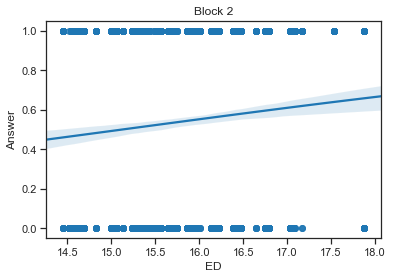

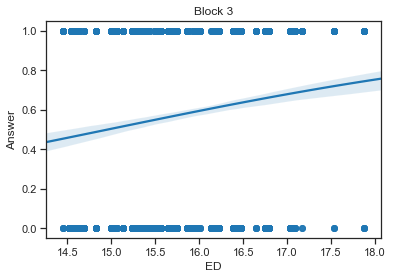

In [40]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=df_concat[ (df_concat['Choice'] != 99)
                               & (df_concat['ED'] > 10)
                               & (df_concat['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

**Conclusions explorative Accuracy analysis:**

Much like with reaction times, there does not seem to be much of a statistical relationship between HMAX difference and accuracies. The same reasoning holds that an iference analysis could yield an interaction between time (i.e. block) and ED, which would signal learning depends on loss of visual information. **The question is if this would be worth it.** Right now, it doesn't look very promising.

# Discrimination task

## Stimuli and Design of Experiment 2

Stimuli and design in Experiment 2 were the same as in Experiment 1 except that there were always 4 alternative choices across all blocks, and the time limit for accepting response was 3s. There was an additional post-test which took place one week later. The post-test consisted of a block of the naming task, and a block of the discrimination task, which was the same as the task during training. The order of the two blocks in the post-test was fixed in the way that the first block was always the same as the last block during training.

**Sidenote**: *Above chance accuracies (ACA)* were the main measure of performance in Lihui's analysis. There, she subtracted the chance level  (which depended on the number of distractors) from the average accuracy in each block. If we want to set up a trial-wise model, we cannot do that.

## Load discrimination task data

And add ED, subject number, as well as ACA

In [41]:
# sorted list of hdf files
disc_files = sorted(glob.glob(datadir+'/*Discrimination*'))
assert len(disc_files) == 32

# Read all files in pandas
disc_dfs = [pd.read_hdf(disc_file) for disc_file in disc_files]

# insert EDs and CDs
disc_dfs = [insert_eds(df, ed_dicts) for df in disc_dfs]
disc_dfs = [insert_cds(df, cd_dicts) for df in disc_dfs]

# iterate through dfs
for df, sub_num in zip(disc_dfs, range(1,len(disc_dfs)+1)):
    
    # add subject number
    df['sub'] = sub_num

    # compute and insert ACA
    for block in range(3):
        df.loc[df['Block'] == block,'ACA'] = (np.mean(df.loc[df['Block'] == block, 'Answer']) - .25)
    
# concatinate into one data frame
disc_df = pd.concat(disc_dfs)

# add task variable
disc_df['task'] = 'disc'

In [42]:
disc_df.head()

,Img,ImgName,AlterImgs,Answer,Choice,RT,MousePos,Block,Trlnum,ED,CD,sub,ACA,task
0,stim_set/Flasche.1_v2_percept.png,Flasche,"[stim_set/Schere.3_v2_percept.png, stim_set/Lo...",1,0,1.762020,"[-0.55625, -0.172222222222]",0,0,15.323762,1.140978,1,0.484375,disc
1,stim_set/Zahnpasta.7_v2_percept.png,Zahnpasta,"[stim_set/Banane.1_v2_percept.png, stim_set/Gl...",0,99,0.000000,"[0.144791666667, -0.214814814815]",0,1,14.634605,0.732023,1,0.484375,disc
2,stim_set/Banane.1_v2_percept.png,Banane,"[stim_set/Schere.4_v2_percept.png, stim_set/Ta...",0,1,1.705525,"[0.289583333333, -0.0685185185185]",0,2,15.745837,0.365693,1,0.484375,disc
3,stim_set/Loeffel.8_v2_percept.png,Löffel,"[stim_set/Banane.2_v2_percept.png, stim_set/Ta...",1,0,1.595861,"[-0.177083333333, -0.283333333333]",0,3,15.238930,0.749405,1,0.484375,disc
4,stim_set/Loeffel.2_v2_percept.png,Löffel,"[stim_set/Apfel.8_v2_percept.png, stim_set/Ban...",1,0,1.622645,"[0.2125, -0.168518518519]",0,4,14.996077,0.861587,1,0.484375,disc


## Are ED and CD correlated?

In [43]:
# Sort both cd and ed list of dicts by stimulus, so we can compare.
cd_dicts_bystim = sorted(cd_dicts, key=lambda k: k['sim'])
ed_dicts_bystim = sorted(ed_dicts, key=lambda k: k['sim'])

In [44]:
# make sure it's correct
assert len(cd_dicts_bystim) == 64 & len(ed_dicts_bystim) == 64
for cd_dict, ed_dict in zip(cd_dicts, ed_dicts):
    assert ed_dict['sim'] in cd_dict['sim']

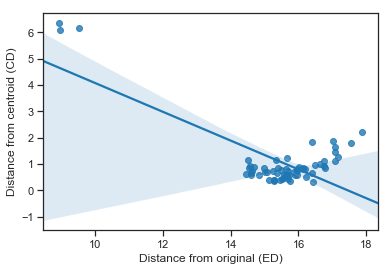

Correlation between ED and CD (with outliers): -0.734


In [45]:
sns.regplot(x=[ed_dict['ed'] for ed_dict in ed_dicts_bystim],
            y=[cd_dict['cd'] for cd_dict in cd_dicts_bystim])
plt.xlabel('Distance from original (ED)')
plt.ylabel('Distance from centroid (CD)')
plt.show()

corr = np.corrcoef(x=[ed_dict['ed'] for ed_dict in ed_dicts_bystim],
                   y=[cd_dict['cd'] for cd_dict in cd_dicts_bystim])[0][1]

print('Correlation between ED and CD (with outliers): %.3f' % corr)

**Conclusion:**
- If we leave in the apples, there is a negative correlation between ED and CD.
- However, the plot suggests that if we cut the apples, the correlation is actually positive.

### Exclude apples

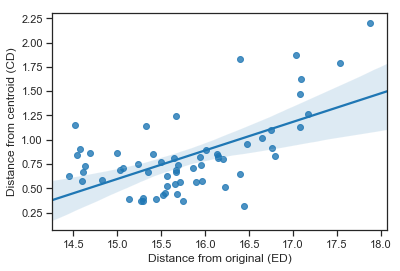

Correlation between ED and CD (outliers removed): 0.593


In [46]:
# we know the outliers are the lowest 3 values

# define new variables, else it gets too cluttered
ed_x = [ed_dict['ed'] for ed_dict in ed_dicts_bystim[3:]]
cd_y = [cd_dict['cd'] for cd_dict in cd_dicts_bystim[3:]]

sns.regplot(x=ed_x, y=cd_y)
plt.xlabel('Distance from original (ED)')
plt.ylabel('Distance from centroid (CD)')
plt.show()

corr = np.corrcoef(x=ed_x, y=cd_y)[0][1]

print('Correlation between ED and CD (outliers removed): %.3f' % corr)

**Conclusions:**
- So if we remove the apples, the correlation between ED and CD is actually positive and substantial.
- Yet, The two measures may still contain independent information which both can be considered for modelling.

## ACAs per block

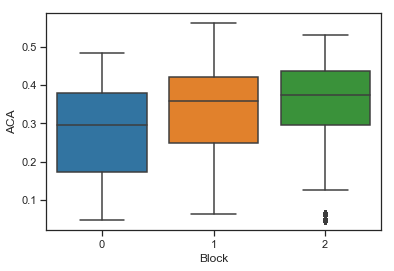

In [47]:
sns.boxplot(data=disc_df, x='Block', y='ACA')

## Logistic plot for Accuracy by ED for each block

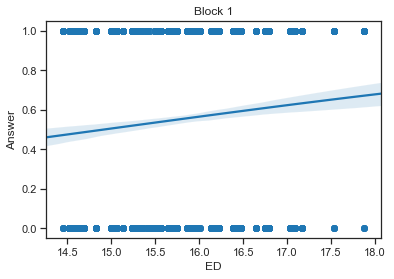

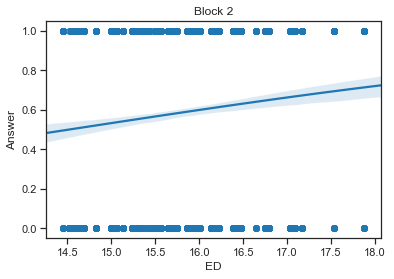

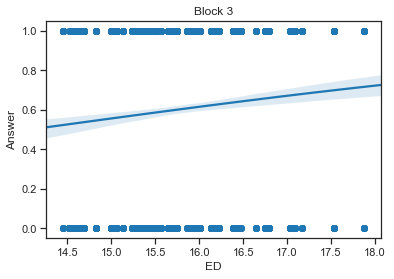

In [48]:
for block in range(3):
    sns.regplot(y='Answer', x='ED',
                data=disc_df[ (disc_df['Choice'] != 99)
                               & (disc_df['ED'] > 10)
                               & (disc_df['Block'] == block)],
                logistic=True, n_boot=200)
    plt.title('Block %i' % (block+1))
    plt.show()

## Reaction times by ED and block

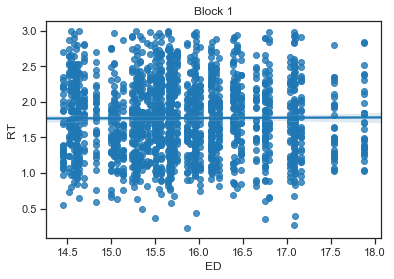

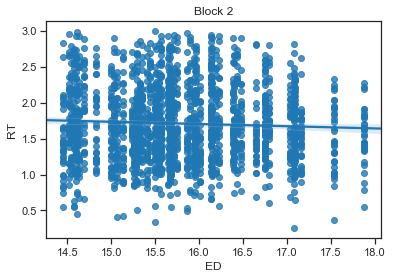

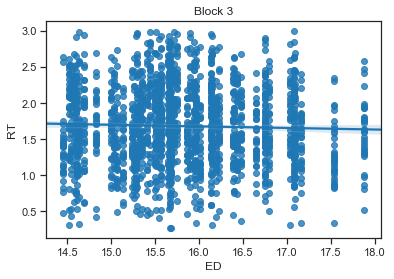

In [49]:
for block in xrange(3):
    ax = sns.regplot(x='ED', y='RT',
                     data=disc_df[(
                         disc_df['Block']==block) & (disc_df['Choice']!=99) & (disc_df['ED'] > 10)
                                   ])
    plt.title('Block %i' % (block+1))
    plt.show()

# Logistic LME on accuracies (with R)

In [50]:
# Load rpy
from rpy2.robjects import r, pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

## install R packages with conda

needs to be done in terminal, because console expects input (y/n)

- essential packages: *conda install -c r r-essentials*

- individual packages: *conda install -c r r-lme4*

In [51]:
%%R

library(lme4)
#library(tidyverse)
library(ggplot2)
library(multcomp)
library(brms)

/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: mvtnorm

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: survival

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: TH.data

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Lade nötiges Paket: MASS

  warnings.warn(x, RRuntimeWarning)
/Users/Oliver/anaconda2/envs/run_hmax/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186:

## Prepare padas df and import in R

In [52]:
# Remove non-response trials from data frame
disc_df_r = disc_df[disc_df.Choice!=99]

# drop irrelevant columns from pandas df to avoid rpy2 import error
dropcols = ['Img', 'ImgName', 'AlterImgs', 'MousePos', 'ACA']
disc_df_r = disc_df_r.drop(columns=dropcols)

# Convert variables to string which should be treated as catigorical by R
for col in ['sub', 'Answer', 'Block']:
    disc_df_r[col] = disc_df_r[col].astype('str')

In [53]:
%%R -i disc_df_r
# Load data frame into R

# Make Block an ordered factor, since we are interested in a linear change across time.
disc_df_r$Block <- factor(disc_df_r$Block, ordered=TRUE)

# Show structure of imported data frame
str(disc_df_r)

'data.frame':	5953 obs. of  9 variables:
 $ Answer: Factor w/ 2 levels "0","1": 2 1 2 2 2 1 2 2 2 2 ...
 $ Choice: int  0 1 0 0 0 3 0 0 0 0 ...
 $ RT    : num  1.76 1.71 1.6 1.62 1.87 ...
 $ Block : Ord.factor w/ 3 levels "0"<"1"<"2": 1 1 1 1 1 1 1 1 1 1 ...
 $ Trlnum: int  0 2 3 4 5 6 7 9 10 11 ...
 $ ED    : num  15.3 15.7 15.2 15 15.7 ...
 $ CD    : num  1.141 0.366 0.749 0.862 0.442 ...
 $ sub   : Factor w/ 32 levels "1","10","11",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ task  : Factor w/ 1 level "disc": 1 1 1 1 1 1 1 1 1 1 ...


In [54]:
%%R
# Show data frame head
head(disc_df_r)

  Answer Choice       RT Block Trlnum       ED        CD sub task
1      1      0 1.762020     0      0 15.32376 1.1409781   1 disc
2      0      1 1.705525     0      2 15.74584 0.3656934   1 disc
3      1      0 1.595861     0      3 15.23893 0.7494049   1 disc
4      1      0 1.622645     0      4 14.99608 0.8615870   1 disc
5      1      0 1.871957     0      5 15.68364 0.4424585   1 disc
6      0      3 2.303956     0      6 15.51642 0.4315332   1 disc


## Logistic mixed model

- We want to predict the Answer by block, ED, and an interaction of Block X ED.
- We also want a random intercept for each subject…
- and a random slope of the effect of block for each subject.

In [55]:
%%R

# Set up a full factorial model (Block*ED entails Block + ED + Block:ED)
# With random slopes of Block for each subject
# And random intercepts for individual subjects (automatically included in Block|sub)

model_full <- glmer(Answer ~ Block*ED + (Block|sub),
                    data=disc_df_r, family=binomial)

summary(model_full)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Answer ~ Block * ED + (Block | sub)
   Data: disc_df_r

     AIC      BIC   logLik deviance df.resid 
  7860.9   7941.2  -3918.5   7836.9     5941 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8666 -1.1055  0.6573  0.8021  1.5754 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub    (Intercept) 0.18590  0.4312              
        Block.L     0.05483  0.2342    0.02      
        Block.Q     0.03012  0.1736   -0.02 -1.00
Number of obs: 5953, groups:  sub, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.21317    0.27800   4.364 1.28e-05 ***
Block.L     -0.11823    0.46720  -0.253  0.80021    
Block.Q      0.30931    0.46186   0.670  0.50305    
ED          -0.05337    0.01715  -3.111  0.00186 ** 
Block.L:ED   0.01634    0.02985   0.547  0.58407    
Block.Q:ED  -0.02092    0.029

**Note:**

- The full factorial model (with main effects for both block and ED as well as their interaction) **failed to converge**
- We try simpler models now by first removing random slopes for block, but keeping the random intercepts for subjects

In [56]:
%%R
#model_simpler1 <- glmer(Answer ~ Block*ED + (1|sub),
#                 data=disc_df_r, family=binomial)
#summary(model_simpler1)

NULL


- The model still **failed to converge**.
- However, we definitely do not want to remove the random intercepts for subjects.
- Next, we try to remove the interaction, but only keep the main effects.
- We also keep our desired random effects setup.

In [57]:
%%R
model_simpler2 <- glmer(Answer ~ Block + ED + (Block|sub),
                        data=disc_df_r, family=binomial)

In [58]:
%%R
summary(model_simpler2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Answer ~ Block + ED + (Block | sub)
   Data: disc_df_r

     AIC      BIC   logLik deviance df.resid 
  7857.7   7924.7  -3918.9   7837.7     5943 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8696 -1.1043  0.6570  0.8031  1.5370 

Random effects:
 Groups Name        Variance Std.Dev. Corr       
 sub    (Intercept) 0.18588  0.4311              
        Block.L     0.05468  0.2338    0.02      
        Block.Q     0.03006  0.1734   -0.02 -1.00
Number of obs: 5953, groups:  sub, 32

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.21287    0.27798   4.363 1.28e-05 ***
Block.L      0.13513    0.06273   2.154  0.03123 *  
Block.Q     -0.01512    0.05607  -0.270  0.78746    
ED          -0.05336    0.01715  -3.111  0.00187 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of

## Model comparison: With ED vs. without

- **#TODO:** Likelihood ratio test comparing model with (fixed) factor and without

### ANOVA

In [59]:
%%R
# ANOVA: Compare model with and without ED as fixed effect

with_ED <- glmer(Answer ~ Block + ED + (Block|sub),
                 data=disc_df_r, family=binomial)

without_ED <- glmer(Answer ~ Block + (Block|sub),
                    data=disc_df_r, family=binomial)

anova_results <- anova(with_ED, without_ED)
anova_results

Data: disc_df_r
Models:
without_ED: Answer ~ Block + (Block | sub)
with_ED: Answer ~ Block + ED + (Block | sub)
           Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)   
without_ED  9 7865.6 7925.9 -3923.8   7847.6                            
with_ED    10 7857.7 7924.7 -3918.9   7837.7 9.8797      1   0.001671 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


### Conclusions

- We see an improvement of fit when adding ED as a predictor in the model
- As stated in the output of the model with ED (above), the **regression weight put on ED is negative**
- This indicates that a larger ED leads to a decreased probability of the participant responding correctly.
- By the way, this is also in line with what we see from the posterior probabilities estimated in a bayesian frameworks with bambi above. There, the distribution of the ED main effect is pushed below zero, while the one for the interaction remains largely unchanged.

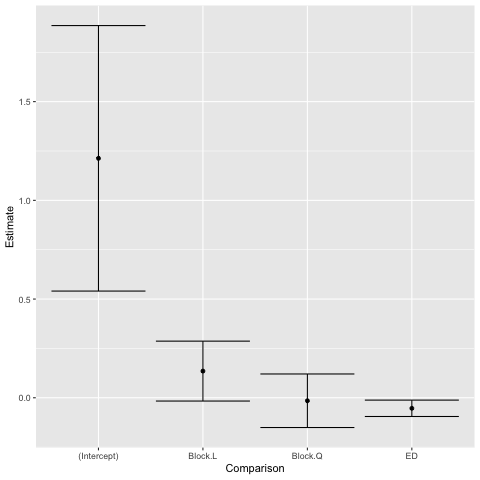

In [60]:
%%R
# Plot parameter estimates with confidence intervals

# temporary df for confidence intervals
temp_df <- as.data.frame(confint(glht(with_ED))$confint)
temp_df$Comparison <- rownames(temp_df)
# plotting function
ggplot(temp_df, aes(x = Comparison, y = Estimate, ymin = lwr, ymax = upr)) + geom_errorbar() + geom_point()

### Converged
- The model yields **significant fixed effects of Block and ED.**
- Next, we could **compare** the model with ED to a model without ED and see if it fits better.
- Convegence issues:
  - In order to look at the **interaction** between Block and ED, we have to omit either as fixed factor in order for the model to converge (see below)
  - When changing the random effects structure to (1|Block) + (1|sub), the pattern of results remains the same. The random effects structure (Block|sub) + (1|sub) fails to converge.
- **#TODO:**
  - Look up what Block.L and Block.Q means in these results.

## Interaction model

In [61]:
%%R
# In order to reach convergence, either Block or ED has to be ommitted as fixed factor.
withint <- glmer(Answer ~ ED + ED:Block + (1|sub) + (1|Block),
                        data=disc_df_r, family=binomial)
summary(withint)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: Answer ~ ED + ED:Block + (1 | sub) + (1 | Block)
   Data: disc_df_r

     AIC      BIC   logLik deviance df.resid 
  7861.7   7901.8  -3924.8   7849.7     5947 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.8517 -1.1089  0.6616  0.8024  1.5707 

Random effects:
 Groups Name        Variance Std.Dev.
 sub    (Intercept) 0.1832   0.4281  
 Block  (Intercept) 0.0000   0.0000  
Number of obs: 5953, groups:  sub, 32; Block, 3

Fixed effects:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.205589   0.277011   4.352 1.35e-05 ***
ED          -0.053072   0.017098  -3.104  0.00191 ** 
ED:Block.L   0.009153   0.003003   3.048  0.00231 ** 
ED:Block.Q  -0.001377   0.002995  -0.460  0.64569    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
           (Intr) ED     ED:B.L
ED        

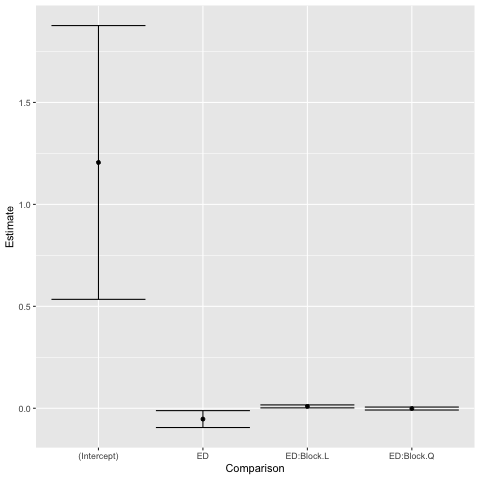

In [62]:
%%R
# Plot estimated parameters of our interaction model

# temporary df for confidence intervals
temp_df_withint <- as.data.frame(confint(glht(withint))$confint)
temp_df_withint$Comparison <- rownames(temp_df_withint)
# plotting function
ggplot(temp_df_withint, aes(x = Comparison, y = Estimate, ymin = lwr, ymax = upr)) + geom_errorbar() + geom_point()

### Conclusions from interaction model:

- The interaction between ED and Block is significant, but the model only convergens if we take out either Block or ED as a fixed effect. 
- The interaction proves significant in either case.
- When leaving Block in instead of ED, Block has no significant main effect. (also when removing the random intercepts for Block)

### TODO:
- Can we plot the slopes of ED for the three blocks seperately?
- Again, find out what the difference between "Block.L" and "Block.Q" is ...

# Save RData for modelling outside of this notebook

## Full data frame for discrimination task data: disc_df_brms

In [84]:
%%R

# BRMS requires the response to be numeric for binomial models

disc_df_brms <- disc_df_r
disc_df_brms$Answer <- as.numeric(disc_df_brms$Answer)

# structure of new data frame
# str(disc_df_brms)

## Slice of discrimination task data: test_df

In [85]:
%%R

# shrink data frame for testing purposes

# choose only sub 1 and 2  for testing
test_df <- disc_df_brms[disc_df_brms$sub==1 | disc_df_brms$sub==2, ] # pipe is the logical OR here.
# Only take the first half of trials
test_df <- test_df[test_df$Trlnum <= 32,]

#str(test_df)

## Save workspace

In [80]:
%%R
# save entire R workspace
save.image(file = "prepped_data.RData", version = NULL, safe = TRUE)